# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

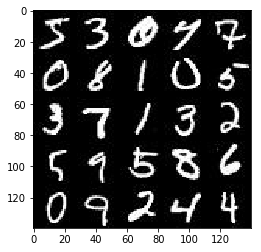

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

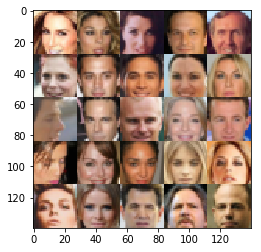

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\betul\Anaconda3\envs\dog-project\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img=tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_image")
    input_z=tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate=tf.placeholder(tf.float32, name="learning_rate")
    return input_img, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1=tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1=tf.maximum(alpha*x1,x1)
        
        x2=tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2=tf.layers.batch_normalization(x2, training=True)
        relu2=tf.maximum(alpha*bn2,bn2)
    
        x3=tf.layers.conv2d(relu2, 256, 5,strides=2, padding='same')
        bn3=tf.layers.batch_normalization(x3, training=True)
        relu3=tf.maximum(alpha*bn3,bn3)
        
        flat=tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss_total = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss_total = d_loss_real + d_loss_fake

    return d_loss_total, g_loss_total



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images*2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                # Get the losses
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                #print the loseses
            
                    print("Step: {}...".format(steps),
                          "Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator loss: {:.4f}...".format(train_loss_d),
                          "Generator loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step: 10... Epoch 1/2... Discriminator loss: 0.5995... Generator loss: 1.2419
Step: 20... Epoch 1/2... Discriminator loss: 0.4180... Generator loss: 5.7455
Step: 30... Epoch 1/2... Discriminator loss: 0.1375... Generator loss: 4.6354
Step: 40... Epoch 1/2... Discriminator loss: 3.7162... Generator loss: 11.6468
Step: 50... Epoch 1/2... Discriminator loss: 0.1856... Generator loss: 2.5397
Step: 60... Epoch 1/2... Discriminator loss: 0.2696... Generator loss: 3.0036
Step: 70... Epoch 1/2... Discriminator loss: 0.1787... Generator loss: 6.8482
Step: 80... Epoch 1/2... Discriminator loss: 0.2798... Generator loss: 2.2549
Step: 90... Epoch 1/2... Discriminator loss: 0.2626... Generator loss: 4.4634
Step: 100... Epoch 1/2... Discriminator loss: 0.4709... Generator loss: 2.1010


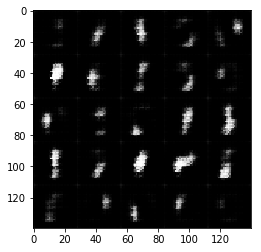

Step: 110... Epoch 1/2... Discriminator loss: 2.6255... Generator loss: 5.9412
Step: 120... Epoch 1/2... Discriminator loss: 0.5573... Generator loss: 1.3860
Step: 130... Epoch 1/2... Discriminator loss: 0.9932... Generator loss: 1.0661
Step: 140... Epoch 1/2... Discriminator loss: 1.2502... Generator loss: 0.7306
Step: 150... Epoch 1/2... Discriminator loss: 1.0353... Generator loss: 0.7727
Step: 160... Epoch 1/2... Discriminator loss: 0.8055... Generator loss: 1.0449
Step: 170... Epoch 1/2... Discriminator loss: 0.5742... Generator loss: 1.7348
Step: 180... Epoch 1/2... Discriminator loss: 0.9600... Generator loss: 0.9426
Step: 190... Epoch 1/2... Discriminator loss: 0.9395... Generator loss: 0.9134
Step: 200... Epoch 1/2... Discriminator loss: 1.1281... Generator loss: 0.9501


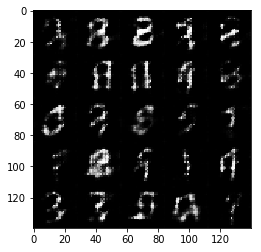

Step: 210... Epoch 1/2... Discriminator loss: 1.2098... Generator loss: 0.6955
Step: 220... Epoch 1/2... Discriminator loss: 0.9458... Generator loss: 1.9212
Step: 230... Epoch 1/2... Discriminator loss: 1.8345... Generator loss: 0.3347
Step: 240... Epoch 1/2... Discriminator loss: 0.6236... Generator loss: 1.3304
Step: 250... Epoch 1/2... Discriminator loss: 0.8642... Generator loss: 1.7304
Step: 260... Epoch 1/2... Discriminator loss: 1.0143... Generator loss: 0.7568
Step: 270... Epoch 1/2... Discriminator loss: 0.7467... Generator loss: 1.5115
Step: 280... Epoch 1/2... Discriminator loss: 0.7233... Generator loss: 1.6821
Step: 290... Epoch 1/2... Discriminator loss: 1.2969... Generator loss: 1.8297
Step: 300... Epoch 1/2... Discriminator loss: 1.0944... Generator loss: 0.6963


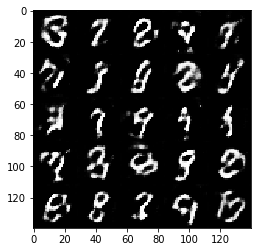

Step: 310... Epoch 1/2... Discriminator loss: 0.8211... Generator loss: 0.8933
Step: 320... Epoch 1/2... Discriminator loss: 0.9454... Generator loss: 0.9389
Step: 330... Epoch 1/2... Discriminator loss: 1.2689... Generator loss: 1.9666
Step: 340... Epoch 1/2... Discriminator loss: 1.0925... Generator loss: 1.0043
Step: 350... Epoch 1/2... Discriminator loss: 0.9360... Generator loss: 1.8412
Step: 360... Epoch 1/2... Discriminator loss: 1.0451... Generator loss: 0.7859
Step: 370... Epoch 1/2... Discriminator loss: 1.1155... Generator loss: 1.9399
Step: 380... Epoch 1/2... Discriminator loss: 0.6794... Generator loss: 1.6395
Step: 390... Epoch 1/2... Discriminator loss: 0.8645... Generator loss: 1.0347
Step: 400... Epoch 1/2... Discriminator loss: 1.1269... Generator loss: 0.6835


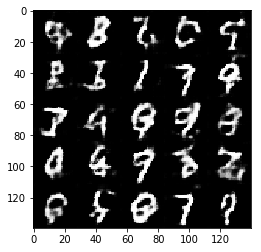

Step: 410... Epoch 1/2... Discriminator loss: 1.0119... Generator loss: 0.9648
Step: 420... Epoch 1/2... Discriminator loss: 0.8166... Generator loss: 1.0228
Step: 430... Epoch 1/2... Discriminator loss: 0.9212... Generator loss: 2.0177
Step: 440... Epoch 1/2... Discriminator loss: 1.0492... Generator loss: 0.9049
Step: 450... Epoch 1/2... Discriminator loss: 1.0917... Generator loss: 0.6704
Step: 460... Epoch 1/2... Discriminator loss: 1.0377... Generator loss: 0.9403
Step: 470... Epoch 2/2... Discriminator loss: 0.9346... Generator loss: 1.2094
Step: 480... Epoch 2/2... Discriminator loss: 0.8153... Generator loss: 0.9239
Step: 490... Epoch 2/2... Discriminator loss: 1.0629... Generator loss: 0.7824
Step: 500... Epoch 2/2... Discriminator loss: 0.9630... Generator loss: 1.2211


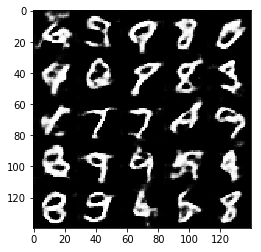

Step: 510... Epoch 2/2... Discriminator loss: 0.7718... Generator loss: 1.1763
Step: 520... Epoch 2/2... Discriminator loss: 0.9419... Generator loss: 0.9651
Step: 530... Epoch 2/2... Discriminator loss: 1.2537... Generator loss: 1.8298
Step: 540... Epoch 2/2... Discriminator loss: 1.0656... Generator loss: 0.7523
Step: 550... Epoch 2/2... Discriminator loss: 1.3336... Generator loss: 2.0373
Step: 560... Epoch 2/2... Discriminator loss: 0.9067... Generator loss: 1.2650
Step: 570... Epoch 2/2... Discriminator loss: 1.2215... Generator loss: 0.5681
Step: 580... Epoch 2/2... Discriminator loss: 0.9252... Generator loss: 1.5879
Step: 590... Epoch 2/2... Discriminator loss: 1.2596... Generator loss: 0.5617
Step: 600... Epoch 2/2... Discriminator loss: 0.9819... Generator loss: 0.7002


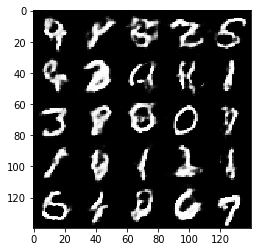

Step: 610... Epoch 2/2... Discriminator loss: 1.1412... Generator loss: 1.1011
Step: 620... Epoch 2/2... Discriminator loss: 1.0498... Generator loss: 0.9268
Step: 630... Epoch 2/2... Discriminator loss: 0.9328... Generator loss: 1.1333
Step: 640... Epoch 2/2... Discriminator loss: 1.1482... Generator loss: 0.6700
Step: 650... Epoch 2/2... Discriminator loss: 1.0076... Generator loss: 0.9011
Step: 660... Epoch 2/2... Discriminator loss: 1.1654... Generator loss: 0.7203
Step: 670... Epoch 2/2... Discriminator loss: 0.9275... Generator loss: 0.8690
Step: 680... Epoch 2/2... Discriminator loss: 1.7262... Generator loss: 0.3246
Step: 690... Epoch 2/2... Discriminator loss: 0.8592... Generator loss: 1.4029
Step: 700... Epoch 2/2... Discriminator loss: 1.0271... Generator loss: 0.7761


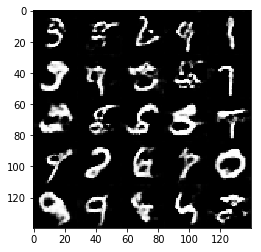

Step: 710... Epoch 2/2... Discriminator loss: 1.1825... Generator loss: 0.5379
Step: 720... Epoch 2/2... Discriminator loss: 0.8638... Generator loss: 1.0357
Step: 730... Epoch 2/2... Discriminator loss: 0.8514... Generator loss: 0.9228
Step: 740... Epoch 2/2... Discriminator loss: 1.0047... Generator loss: 0.7478
Step: 750... Epoch 2/2... Discriminator loss: 1.1020... Generator loss: 0.8301
Step: 760... Epoch 2/2... Discriminator loss: 0.9397... Generator loss: 0.9869
Step: 770... Epoch 2/2... Discriminator loss: 1.0117... Generator loss: 0.8684
Step: 780... Epoch 2/2... Discriminator loss: 1.0300... Generator loss: 1.0857
Step: 790... Epoch 2/2... Discriminator loss: 0.9182... Generator loss: 0.9716
Step: 800... Epoch 2/2... Discriminator loss: 1.0030... Generator loss: 1.1240


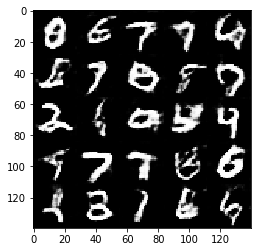

Step: 810... Epoch 2/2... Discriminator loss: 1.0068... Generator loss: 0.7283
Step: 820... Epoch 2/2... Discriminator loss: 1.0672... Generator loss: 0.7556
Step: 830... Epoch 2/2... Discriminator loss: 0.8708... Generator loss: 1.0939
Step: 840... Epoch 2/2... Discriminator loss: 0.9028... Generator loss: 1.1549
Step: 850... Epoch 2/2... Discriminator loss: 1.1271... Generator loss: 1.4207
Step: 860... Epoch 2/2... Discriminator loss: 0.8602... Generator loss: 0.9224
Step: 870... Epoch 2/2... Discriminator loss: 1.8374... Generator loss: 0.2822
Step: 880... Epoch 2/2... Discriminator loss: 1.0408... Generator loss: 1.2018
Step: 890... Epoch 2/2... Discriminator loss: 1.1206... Generator loss: 1.6152
Step: 900... Epoch 2/2... Discriminator loss: 1.2437... Generator loss: 1.9831


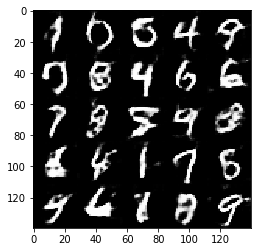

Step: 910... Epoch 2/2... Discriminator loss: 1.1663... Generator loss: 0.9876
Step: 920... Epoch 2/2... Discriminator loss: 0.8889... Generator loss: 1.0427
Step: 930... Epoch 2/2... Discriminator loss: 0.9265... Generator loss: 0.9197


In [28]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step: 10... Epoch 1/1... Discriminator loss: 0.3090... Generator loss: 13.0706
Step: 20... Epoch 1/1... Discriminator loss: 0.0807... Generator loss: 9.8320
Step: 30... Epoch 1/1... Discriminator loss: 0.0752... Generator loss: 6.0100
Step: 40... Epoch 1/1... Discriminator loss: 0.4497... Generator loss: 3.2388
Step: 50... Epoch 1/1... Discriminator loss: 0.2048... Generator loss: 5.3091
Step: 60... Epoch 1/1... Discriminator loss: 0.5613... Generator loss: 3.1982
Step: 70... Epoch 1/1... Discriminator loss: 1.1736... Generator loss: 3.0750
Step: 80... Epoch 1/1... Discriminator loss: 1.9960... Generator loss: 0.2851
Step: 90... Epoch 1/1... Discriminator loss: 0.6318... Generator loss: 1.5128
Step: 100... Epoch 1/1... Discriminator loss: 0.4722... Generator loss: 2.3856


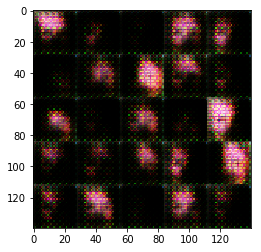

Step: 110... Epoch 1/1... Discriminator loss: 0.4921... Generator loss: 2.4958
Step: 120... Epoch 1/1... Discriminator loss: 1.0491... Generator loss: 0.6440
Step: 130... Epoch 1/1... Discriminator loss: 1.6406... Generator loss: 0.5992
Step: 140... Epoch 1/1... Discriminator loss: 0.7253... Generator loss: 1.3639
Step: 150... Epoch 1/1... Discriminator loss: 1.0404... Generator loss: 1.2789
Step: 160... Epoch 1/1... Discriminator loss: 1.9043... Generator loss: 3.6174
Step: 170... Epoch 1/1... Discriminator loss: 0.5968... Generator loss: 1.3252
Step: 180... Epoch 1/1... Discriminator loss: 0.7388... Generator loss: 1.2633
Step: 190... Epoch 1/1... Discriminator loss: 1.0669... Generator loss: 1.1758
Step: 200... Epoch 1/1... Discriminator loss: 1.1792... Generator loss: 0.8095


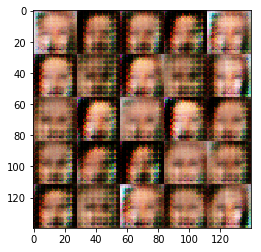

Step: 210... Epoch 1/1... Discriminator loss: 1.5337... Generator loss: 1.6483
Step: 220... Epoch 1/1... Discriminator loss: 2.0701... Generator loss: 2.9505
Step: 230... Epoch 1/1... Discriminator loss: 1.3486... Generator loss: 1.2070
Step: 240... Epoch 1/1... Discriminator loss: 1.4307... Generator loss: 2.5577
Step: 250... Epoch 1/1... Discriminator loss: 1.2027... Generator loss: 0.7232
Step: 260... Epoch 1/1... Discriminator loss: 1.1270... Generator loss: 0.6495
Step: 270... Epoch 1/1... Discriminator loss: 0.9916... Generator loss: 1.5411
Step: 280... Epoch 1/1... Discriminator loss: 1.4833... Generator loss: 2.3838
Step: 290... Epoch 1/1... Discriminator loss: 1.2174... Generator loss: 1.0149
Step: 300... Epoch 1/1... Discriminator loss: 1.2925... Generator loss: 0.7049


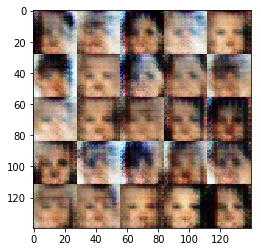

Step: 310... Epoch 1/1... Discriminator loss: 1.7132... Generator loss: 0.2512
Step: 320... Epoch 1/1... Discriminator loss: 1.3441... Generator loss: 0.4683
Step: 330... Epoch 1/1... Discriminator loss: 2.0688... Generator loss: 1.7901
Step: 340... Epoch 1/1... Discriminator loss: 1.3308... Generator loss: 0.7981
Step: 350... Epoch 1/1... Discriminator loss: 1.1782... Generator loss: 0.8204
Step: 360... Epoch 1/1... Discriminator loss: 1.4191... Generator loss: 0.4239
Step: 370... Epoch 1/1... Discriminator loss: 1.3836... Generator loss: 1.7923
Step: 380... Epoch 1/1... Discriminator loss: 1.1713... Generator loss: 1.2977
Step: 390... Epoch 1/1... Discriminator loss: 1.2495... Generator loss: 0.5424
Step: 400... Epoch 1/1... Discriminator loss: 0.9585... Generator loss: 0.8173


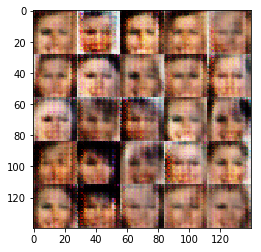

Step: 410... Epoch 1/1... Discriminator loss: 1.7759... Generator loss: 0.3048
Step: 420... Epoch 1/1... Discriminator loss: 1.2658... Generator loss: 0.9986
Step: 430... Epoch 1/1... Discriminator loss: 0.8886... Generator loss: 0.8315
Step: 440... Epoch 1/1... Discriminator loss: 1.8976... Generator loss: 2.7458
Step: 450... Epoch 1/1... Discriminator loss: 1.1641... Generator loss: 0.7642
Step: 460... Epoch 1/1... Discriminator loss: 1.3297... Generator loss: 0.6851
Step: 470... Epoch 1/1... Discriminator loss: 3.2762... Generator loss: 0.0563
Step: 480... Epoch 1/1... Discriminator loss: 1.2156... Generator loss: 0.9452
Step: 490... Epoch 1/1... Discriminator loss: 1.5223... Generator loss: 1.4442
Step: 500... Epoch 1/1... Discriminator loss: 1.2205... Generator loss: 0.8009


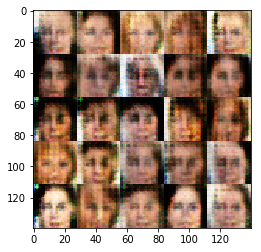

Step: 510... Epoch 1/1... Discriminator loss: 1.2434... Generator loss: 1.2297
Step: 520... Epoch 1/1... Discriminator loss: 0.9198... Generator loss: 0.9972
Step: 530... Epoch 1/1... Discriminator loss: 1.2312... Generator loss: 0.7709
Step: 540... Epoch 1/1... Discriminator loss: 2.2480... Generator loss: 0.1839
Step: 550... Epoch 1/1... Discriminator loss: 0.9517... Generator loss: 1.0432
Step: 560... Epoch 1/1... Discriminator loss: 0.6641... Generator loss: 1.1503
Step: 570... Epoch 1/1... Discriminator loss: 0.9932... Generator loss: 0.9195
Step: 580... Epoch 1/1... Discriminator loss: 1.0465... Generator loss: 1.1037
Step: 590... Epoch 1/1... Discriminator loss: 1.2828... Generator loss: 0.9589
Step: 600... Epoch 1/1... Discriminator loss: 1.0195... Generator loss: 0.9647


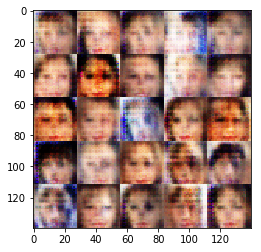

Step: 610... Epoch 1/1... Discriminator loss: 1.6147... Generator loss: 0.3608
Step: 620... Epoch 1/1... Discriminator loss: 1.0402... Generator loss: 1.0135
Step: 630... Epoch 1/1... Discriminator loss: 1.4736... Generator loss: 2.2997
Step: 640... Epoch 1/1... Discriminator loss: 1.0085... Generator loss: 0.9065
Step: 650... Epoch 1/1... Discriminator loss: 3.0683... Generator loss: 2.7694
Step: 660... Epoch 1/1... Discriminator loss: 1.2775... Generator loss: 0.5869
Step: 670... Epoch 1/1... Discriminator loss: 1.0146... Generator loss: 1.3789
Step: 680... Epoch 1/1... Discriminator loss: 1.1349... Generator loss: 1.3923
Step: 690... Epoch 1/1... Discriminator loss: 1.2669... Generator loss: 0.9054
Step: 700... Epoch 1/1... Discriminator loss: 0.9388... Generator loss: 1.0619


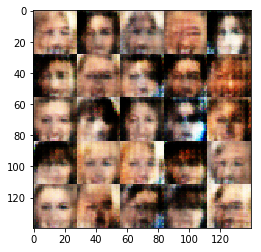

Step: 710... Epoch 1/1... Discriminator loss: 0.9020... Generator loss: 1.2781
Step: 720... Epoch 1/1... Discriminator loss: 1.8725... Generator loss: 2.2158
Step: 730... Epoch 1/1... Discriminator loss: 1.1151... Generator loss: 0.8576
Step: 740... Epoch 1/1... Discriminator loss: 1.2189... Generator loss: 0.8283
Step: 750... Epoch 1/1... Discriminator loss: 1.2092... Generator loss: 0.6452
Step: 760... Epoch 1/1... Discriminator loss: 1.2223... Generator loss: 0.8161
Step: 770... Epoch 1/1... Discriminator loss: 1.1585... Generator loss: 1.4021
Step: 780... Epoch 1/1... Discriminator loss: 1.1580... Generator loss: 0.8939
Step: 790... Epoch 1/1... Discriminator loss: 1.1731... Generator loss: 3.0814
Step: 800... Epoch 1/1... Discriminator loss: 1.1933... Generator loss: 1.0340


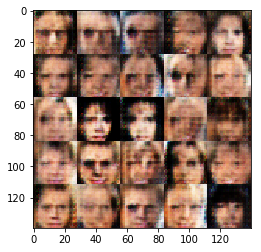

Step: 810... Epoch 1/1... Discriminator loss: 0.8440... Generator loss: 1.0562
Step: 820... Epoch 1/1... Discriminator loss: 0.9024... Generator loss: 0.9384
Step: 830... Epoch 1/1... Discriminator loss: 1.1669... Generator loss: 0.8071
Step: 840... Epoch 1/1... Discriminator loss: 1.3088... Generator loss: 0.5494
Step: 850... Epoch 1/1... Discriminator loss: 1.1020... Generator loss: 1.6933
Step: 860... Epoch 1/1... Discriminator loss: 1.2929... Generator loss: 0.8657
Step: 870... Epoch 1/1... Discriminator loss: 1.2034... Generator loss: 0.7437
Step: 880... Epoch 1/1... Discriminator loss: 1.1852... Generator loss: 0.8019
Step: 890... Epoch 1/1... Discriminator loss: 1.1071... Generator loss: 1.0387
Step: 900... Epoch 1/1... Discriminator loss: 1.1166... Generator loss: 0.6687


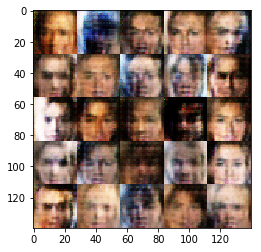

Step: 910... Epoch 1/1... Discriminator loss: 1.1884... Generator loss: 0.6150
Step: 920... Epoch 1/1... Discriminator loss: 1.1898... Generator loss: 2.2244
Step: 930... Epoch 1/1... Discriminator loss: 1.2299... Generator loss: 0.6611
Step: 940... Epoch 1/1... Discriminator loss: 1.1126... Generator loss: 0.8941
Step: 950... Epoch 1/1... Discriminator loss: 1.3542... Generator loss: 2.1011
Step: 960... Epoch 1/1... Discriminator loss: 1.0054... Generator loss: 0.8888
Step: 970... Epoch 1/1... Discriminator loss: 1.2495... Generator loss: 0.9785
Step: 980... Epoch 1/1... Discriminator loss: 1.5212... Generator loss: 0.3765
Step: 990... Epoch 1/1... Discriminator loss: 1.3135... Generator loss: 0.7922
Step: 1000... Epoch 1/1... Discriminator loss: 0.9483... Generator loss: 0.9502


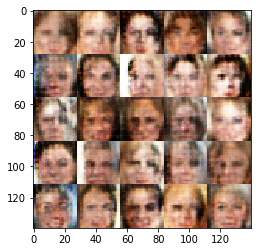

Step: 1010... Epoch 1/1... Discriminator loss: 1.2401... Generator loss: 0.5987
Step: 1020... Epoch 1/1... Discriminator loss: 1.2598... Generator loss: 1.8788
Step: 1030... Epoch 1/1... Discriminator loss: 0.9696... Generator loss: 0.7182
Step: 1040... Epoch 1/1... Discriminator loss: 1.0998... Generator loss: 1.0608
Step: 1050... Epoch 1/1... Discriminator loss: 1.1125... Generator loss: 1.0849
Step: 1060... Epoch 1/1... Discriminator loss: 1.2563... Generator loss: 0.9331
Step: 1070... Epoch 1/1... Discriminator loss: 1.2279... Generator loss: 1.2771
Step: 1080... Epoch 1/1... Discriminator loss: 0.9909... Generator loss: 1.1743
Step: 1090... Epoch 1/1... Discriminator loss: 1.1507... Generator loss: 0.7816
Step: 1100... Epoch 1/1... Discriminator loss: 1.0451... Generator loss: 0.8167


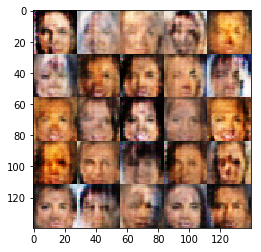

Step: 1110... Epoch 1/1... Discriminator loss: 1.1654... Generator loss: 1.1974
Step: 1120... Epoch 1/1... Discriminator loss: 1.0781... Generator loss: 0.8590
Step: 1130... Epoch 1/1... Discriminator loss: 1.0917... Generator loss: 1.1101
Step: 1140... Epoch 1/1... Discriminator loss: 0.8754... Generator loss: 1.4949
Step: 1150... Epoch 1/1... Discriminator loss: 1.6882... Generator loss: 2.1167
Step: 1160... Epoch 1/1... Discriminator loss: 1.1067... Generator loss: 1.1058
Step: 1170... Epoch 1/1... Discriminator loss: 1.2203... Generator loss: 1.3655
Step: 1180... Epoch 1/1... Discriminator loss: 1.3856... Generator loss: 0.4884
Step: 1190... Epoch 1/1... Discriminator loss: 1.0375... Generator loss: 0.9319
Step: 1200... Epoch 1/1... Discriminator loss: 1.3745... Generator loss: 0.5971


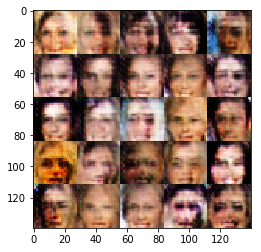

Step: 1210... Epoch 1/1... Discriminator loss: 1.2633... Generator loss: 0.6323
Step: 1220... Epoch 1/1... Discriminator loss: 1.3777... Generator loss: 1.7773
Step: 1230... Epoch 1/1... Discriminator loss: 1.2817... Generator loss: 0.7481
Step: 1240... Epoch 1/1... Discriminator loss: 0.8431... Generator loss: 1.3155
Step: 1250... Epoch 1/1... Discriminator loss: 1.3489... Generator loss: 0.4601
Step: 1260... Epoch 1/1... Discriminator loss: 2.0153... Generator loss: 0.2022
Step: 1270... Epoch 1/1... Discriminator loss: 1.0388... Generator loss: 0.7201
Step: 1280... Epoch 1/1... Discriminator loss: 0.9093... Generator loss: 1.5548
Step: 1290... Epoch 1/1... Discriminator loss: 1.6610... Generator loss: 1.3951
Step: 1300... Epoch 1/1... Discriminator loss: 0.8425... Generator loss: 1.4041


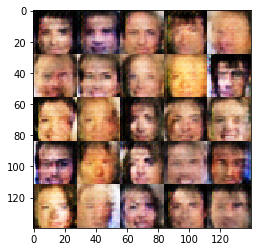

Step: 1310... Epoch 1/1... Discriminator loss: 0.8849... Generator loss: 1.1628
Step: 1320... Epoch 1/1... Discriminator loss: 1.2433... Generator loss: 0.6969
Step: 1330... Epoch 1/1... Discriminator loss: 1.2368... Generator loss: 0.8684
Step: 1340... Epoch 1/1... Discriminator loss: 0.9621... Generator loss: 0.8298
Step: 1350... Epoch 1/1... Discriminator loss: 1.5384... Generator loss: 1.8787
Step: 1360... Epoch 1/1... Discriminator loss: 1.4794... Generator loss: 0.5752
Step: 1370... Epoch 1/1... Discriminator loss: 0.9690... Generator loss: 1.4647
Step: 1380... Epoch 1/1... Discriminator loss: 0.8753... Generator loss: 1.1553
Step: 1390... Epoch 1/1... Discriminator loss: 0.9410... Generator loss: 0.9601
Step: 1400... Epoch 1/1... Discriminator loss: 0.8182... Generator loss: 0.8094


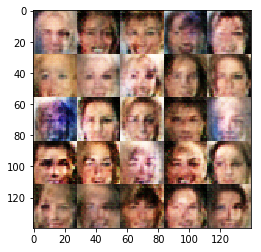

Step: 1410... Epoch 1/1... Discriminator loss: 1.2217... Generator loss: 0.8078
Step: 1420... Epoch 1/1... Discriminator loss: 1.0026... Generator loss: 0.9944
Step: 1430... Epoch 1/1... Discriminator loss: 0.9491... Generator loss: 0.8712
Step: 1440... Epoch 1/1... Discriminator loss: 1.3512... Generator loss: 0.7128
Step: 1450... Epoch 1/1... Discriminator loss: 0.9165... Generator loss: 0.7240
Step: 1460... Epoch 1/1... Discriminator loss: 1.1157... Generator loss: 0.9129
Step: 1470... Epoch 1/1... Discriminator loss: 1.7626... Generator loss: 1.0364
Step: 1480... Epoch 1/1... Discriminator loss: 1.3463... Generator loss: 2.2476
Step: 1490... Epoch 1/1... Discriminator loss: 1.6503... Generator loss: 1.5300
Step: 1500... Epoch 1/1... Discriminator loss: 1.3044... Generator loss: 0.5112


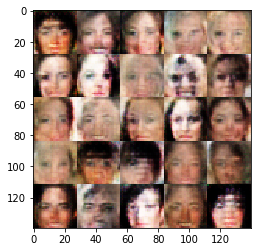

Step: 1510... Epoch 1/1... Discriminator loss: 0.9494... Generator loss: 1.1005
Step: 1520... Epoch 1/1... Discriminator loss: 1.2475... Generator loss: 1.3383
Step: 1530... Epoch 1/1... Discriminator loss: 0.9008... Generator loss: 0.9689
Step: 1540... Epoch 1/1... Discriminator loss: 0.9497... Generator loss: 1.2880
Step: 1550... Epoch 1/1... Discriminator loss: 1.0888... Generator loss: 1.0013
Step: 1560... Epoch 1/1... Discriminator loss: 1.1003... Generator loss: 1.2327
Step: 1570... Epoch 1/1... Discriminator loss: 1.3881... Generator loss: 1.0431
Step: 1580... Epoch 1/1... Discriminator loss: 1.4628... Generator loss: 0.7249


In [30]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.